<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/05_Transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with TensorFlow part 2: Fine-Tuning

In [1]:
!nvidia-smi

Mon Feb 21 03:04:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Creating helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-21 03:04:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-21 03:04:58 (83.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#import helper function we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data,  walk_through_dir

>if you are running this notebook in Google colab, when it times out colab will delete "helper_function".

## Get some data

use pretrained model using tf.keras.application and apply them to our own probelm (recognizing images of food).

In [4]:
# get 10% of training data of 10 fooc classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-21 03:05:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.120.128, 74.125.126.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   105MB/s    in 1.5s    

2022-02-21 03:05:03 (105 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
#create training and test directories paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"


In [7]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

test_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
#check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
#see an example of a batch of data
for image, labels in train_data_10_percent.take(1):
  print(image,labels)

#need to normalize these tensors later

tf.Tensor(
[[[[2.93418369e+01 5.56989784e+01 8.16683655e+01]
   [2.06428547e+01 4.70000000e+01 7.15204086e+01]
   [8.53571415e+00 3.33265305e+01 5.58979607e+01]
   ...
   [3.98520050e+01 8.42805328e+01 1.09494797e+02]
   [2.79540596e+01 6.99540634e+01 9.49540634e+01]
   [3.42195702e+01 7.42195663e+01 1.00219566e+02]]

  [[3.05969391e+01 6.39540825e+01 9.60000000e+01]
   [3.19132633e+01 6.32040787e+01 9.24285660e+01]
   [2.15867329e+01 5.11734695e+01 7.76989822e+01]
   ...
   [4.61989594e+01 9.06274872e+01 1.17413223e+02]
   [5.01377678e+01 9.21377640e+01 1.17137764e+02]
   [4.88570366e+01 8.88570404e+01 1.14857040e+02]]

  [[3.11938782e+01 7.31224518e+01 1.13913269e+02]
   [2.61530609e+01 6.66683655e+01 1.03525513e+02]
   [2.75051003e+01 6.40050964e+01 9.81683655e+01]
   ...
   [4.66173630e+01 9.10458908e+01 1.17831627e+02]
   [5.02142868e+01 9.14285736e+01 1.18785713e+02]
   [5.03418159e+01 8.95560989e+01 1.17913246e+02]]

  ...

  [[1.34857147e+02 1.45642853e+02 1.68285736e+02]
   [1

## model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order.

But the functional API gives us flexibility with our models

---



In [14]:
#1. create base model with tf.keras.applications
base_model= tf.keras.applications.EfficientNetB0(include_top=False)

#2. freeze the base model (so the underlying pre trained patterns are not updating)
base_model.trainable=False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If uisng Resnet50V2 you will need to normalize inputs (you dont have to for EfficientNet)
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Past the input to the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#8. combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220221-031018
Epoch 1/5
24/24 [==============================] - 28s 457ms/step - loss: 1.8882 - accuracy: 0.4107 - val_loss: 1.3658 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 9s 358ms/step - loss: 1.1411 - accuracy: 0.7480 - val_loss: 0.9555 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 9s 362ms/step - loss: 0.8414 - accuracy: 0.8120 - val_loss: 0.7768 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 9s 359ms/step - loss: 0.6958 - accuracy: 0.8360 - val_loss: 0.6841 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 7s 269ms/step - loss: 0.5925 - accuracy: 0.8640 - val_loss: 0.6072 - val_accuracy: 0.8438


In [19]:
#evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 12s 142ms/step - loss: 0.6106 - accuracy: 0.8436


[0.6105808019638062, 0.8435999751091003]

In [23]:
#check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [25]:
#how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [26]:
#how about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


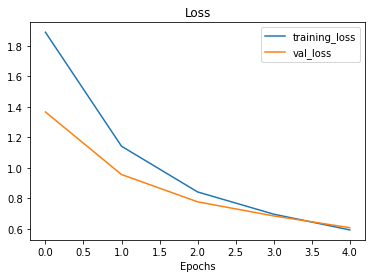

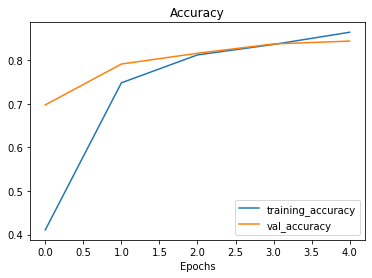

In [27]:
#check out the loss curves of the model
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base model' of shape(None,7,7,1280). 

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280). 

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [35]:
# Define the input shape
input_shape = (1,4,4,3)

#create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

#pass the random tensor through a global average pooling 2D
global_Average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_Average_pooled_tensor}")

#check the shape of the different tensors
print(f"\nShape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D: {global_Average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D: (1, 3)


In [36]:
#Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments
 we have seen the incredible resuts transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

 1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation
 2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.
 3. 'model 3' - use fine-tuning transfer learning oon 10% of the training data with data augmentation.
 4. 'model 4' - use fine-tuning transfer learning on 100% of the training data with data augmentation.

 > **Note** throoughout all experiments the same test dataset will be used too evaluate ur model. this ensures consistency acrooss evaluation metrics.

## Getting preprocessing data

In [38]:
#Download and unzip data -preprocess from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-02-21 03:45:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   111MB/s    in 1.1s    

2022-02-21 03:45:22 (111 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [39]:
#create training and test dir
train_dir_1_percent= "10_food_classes_1_percent/train"
test_dir_1_percent="10_food_classes_1_percent/test"

In [40]:
#how many images we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [45]:
#Setup data loaders
IMG_SIZE=(224,224)

train_data_1_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE) 

test_data_1_percent= tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into our model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()


In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)
                                      #preprocessing.Rescale(1./255) # keep for model like ResNet50V2
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happers to our data)

In [54]:
#View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

#read in the random image
img=mpimg.imread(random_image_path)
print(img)

[[[36 31 28]
  [37 32 29]
  [37 32 29]
  ...
  [42 37 41]
  [42 37 41]
  [41 36 40]]

 [[37 32 29]
  [37 32 29]
  [37 32 29]
  ...
  [43 38 42]
  [42 37 41]
  [42 37 41]]

 [[37 32 29]
  [37 32 29]
  [38 33 30]
  ...
  [43 38 42]
  [43 38 42]
  [42 37 41]]

 ...

 [[ 9  9  9]
  [10 10 10]
  [10 10 10]
  ...
  [24 24 24]
  [24 24 24]
  [23 23 23]]

 [[ 9  9  9]
  [ 9  9  9]
  [10 10 10]
  ...
  [24 24 24]
  [23 23 23]
  [23 23 23]]

 [[ 8  8  8]
  [ 8  8  8]
  [ 9  9  9]
  ...
  [24 24 24]
  [23 23 23]
  [23 23 23]]]
